# Decision Tree & Random Forest — Scikit-Learn

**Dataset:** Bank Marketing (UCI) — 41,188 samples, 19 features, binary classification  
**Task:** Predict term deposit subscription (yes/no)  
**Framework showcase:** GridSearchCV hyperparameter tuning + Partial Dependence Plots

## Structure
- **Part 1: Decision Tree** — Single tree baseline, demonstrates overfitting  
- **Part 2: Random Forest** — Ensemble of 100 bagged trees, fixes overfitting via variance reduction  
- **Showcase:** GridSearchCV + PDP for model interpretability  
- **MLflow:** Experiment tracking + model export for deployment

In [1]:
import numpy as np
import sys
import os
import json

# Add project root to path for shared utilities
sys.path.insert(0, os.path.abspath('../..'))

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay

from utils.data_loader import load_processed_data
from utils.metrics import evaluate_classifier, print_metrics
from utils.performance import track_performance, get_model_size, track_inference
from utils.visualization import (plot_confusion_matrix, plot_roc_curve, 
                                  plot_feature_importance, plot_calibration_curve,
                                  plot_tree_depth_analysis, plot_forest_convergence)
from utils.results import save_results, add_result, print_comparison, build_results_dict

# Configuration
RANDOM_STATE = 113
FRAMEWORK = 'Scikit-Learn'
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Depth values to sweep in Part 1
DEPTH_VALUES = [2, 3, 5, 7, 10, 15, 20, None]

# Load preprocessed data
X_train, X_test, y_train, y_test, metadata = load_processed_data('decision_tree')
feature_names = metadata['feature_names']

print("=" * 60)
print("DECISION TREE & RANDOM FOREST — SCIKIT-LEARN")
print("=" * 60)
print(f"\nDataset: {metadata['dataset']}")
print(f"Features: {metadata['n_features']} ({len(metadata['categorical_features'])} categorical, "
      f"{len(metadata['continuous_features'])} continuous)")
print(f"Training: {X_train.shape[0]:,} samples")
print(f"Test:     {X_test.shape[0]:,} samples")
print(f"Classes:  {metadata['class_names']}")
print(f"Train class dist: 0={np.sum(y_train==0):,}, 1={np.sum(y_train==1):,} "
      f"({np.mean(y_train==1)*100:.1f}% positive)")
print(f"\nDropped: {list(metadata['dropped_features'].keys())} (data leakage)")
print(f"Scaling: {metadata['scaling']}")

DECISION TREE & RANDOM FOREST — SCIKIT-LEARN

Dataset: Bank Marketing (UCI)
Features: 19 (10 categorical, 9 continuous)
Training: 32,950 samples
Test:     8,238 samples
Classes:  ['no', 'yes']
Train class dist: 0=29,238, 1=3,712 (11.3% positive)

Dropped: ['duration'] (data leakage)
Scaling: None (trees are scale-invariant)


In [ ]:
# PART 1 / Step 1: DECISION TREE (Baseline — demonstrates overfitting)
print("=" * 60)
print("PART 1: DECISION TREE (No Depth Limit)")
print("=" * 60)

"""
Train with NO depth restriction — tree will memorize training data
class_weight='balanced' adjusts for 88.7/11.3 imbalance:
weight_class_k = n_samples / (n_classes * n_samples_class_k)
"""
dt_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

with track_performance() as dt_perf:
    dt_model.fit(X_train, y_train)

# Predictions + probabilities
dt_train_pred = dt_model.predict(X_train)
dt_train_proba = dt_model.predict_proba(X_train)[:, 1] # type: ignore
dt_test_pred = dt_model.predict(X_test)
dt_test_proba = dt_model.predict_proba(X_test)[:, 1] # type: ignore

# Evaluate both sets
dt_train_metrics = evaluate_classifier(y_train, dt_train_pred, dt_train_proba)
dt_test_metrics = evaluate_classifier(y_test, dt_test_pred, dt_test_proba)

print(f"\nTraining time: {dt_perf['time']:.4f}s")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")

# Show overfitting: train vs test
print_metrics(dt_train_metrics, dt_test_metrics, title="Decision Tree (Unrestricted)")

print("\n! Notice the gap between train and test metrics — this is OVERFITTING.")
print("The unrestricted tree memorizes the training data perfectly.")

PART 1: DECISION TREE (No Depth Limit)

Training time: 0.1001s
Tree depth: 43
Number of leaves: 6211

METRICS — Decision Tree (Unrestricted)
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.9940       0.8449
precision                       0.9496       0.3196
recall                          1.0000       0.3341
f1                              0.9742       0.3267
auc                             0.9999       0.6095
log_loss                        0.0127       5.1260
brier_score                     0.0045       0.1534
ece                             0.0045       0.0790

! Notice the gap between train and test metrics — this is OVERFITTING.
The unrestricted tree memorizes the training data perfectly.


DEPTH ANALYSIS — Finding Optimal max_depth
  max_depth=2             train=0.8353  test=0.8344  gap=0.0009
  max_depth=3             train=0.8354  test=0.8345  gap=0.0009
  max_depth=5             train=0.8154  test=0.8106  gap=0.0047
  max_depth=7             train=0.8217  test=0.8126  gap=0.0091
  max_depth=10            train=0.8398  test=0.8177  gap=0.0221
  max_depth=15            train=0.8797  test=0.8196  gap=0.0600
  max_depth=20            train=0.9218  test=0.8205  gap=0.1013
  max_depth=None (full)   train=0.9940  test=0.8449  gap=0.1492


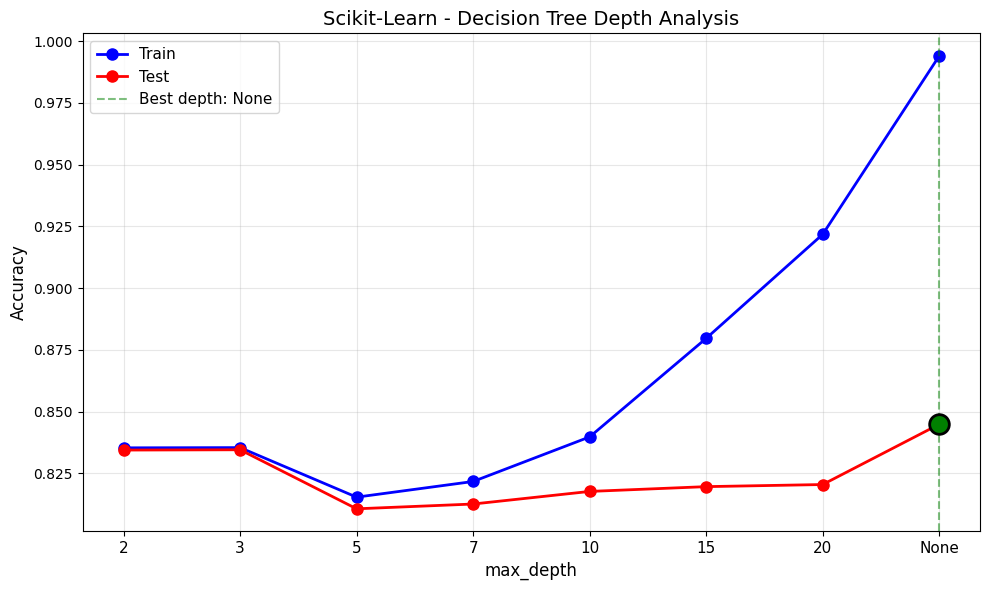


Optimal max_depth: None (test accuracy: 0.8449)

Retraining with max_depth=None...

Tree depth: 43, Leaves: 6211

METRICS — Decision Tree (max_depth=None)
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.9940       0.8449
precision                       0.9496       0.3196
recall                          1.0000       0.3341
f1                              0.9742       0.3267
auc                             0.9999       0.6095
log_loss                        0.0127       5.1260
brier_score                     0.0045       0.1534
ece                             0.0045       0.0790


In [3]:
# Step 2: Depth analysis — find optimal max_depth
print("=" * 60)
print("DEPTH ANALYSIS — Finding Optimal max_depth")
print("=" * 60)

train_scores = []
test_scores = []

for depth in DEPTH_VALUES:
    dt = DecisionTreeClassifier(
        max_depth=depth,
        random_state=RANDOM_STATE,
        class_weight='balanced'
    )
    dt.fit(X_train, y_train)
    
    train_acc = np.mean(dt.predict(X_train) == y_train)
    test_acc = np.mean(dt.predict(X_test) == y_test)
    train_scores.append(train_acc)
    test_scores.append(test_acc)
    
    depth_label = depth if depth is not None else "None (full)"
    print(f"  max_depth={str(depth_label):12s}  train={train_acc:.4f}  test={test_acc:.4f}  "
          f"gap={train_acc - test_acc:.4f}")

# Plot depth analysis
plot_tree_depth_analysis(DEPTH_VALUES, train_scores, test_scores, FRAMEWORK,
                         save_path=f'{RESULTS_DIR}/dt_depth_analysis.png')

# Find optimal depth (highest test accuracy)
best_idx = np.argmax(test_scores)
best_depth = DEPTH_VALUES[best_idx]
print(f"\nOptimal max_depth: {best_depth} (test accuracy: {test_scores[best_idx]:.4f})")

# Retrain with optimal depth
print(f"\nRetraining with max_depth={best_depth}...")
dt_model = DecisionTreeClassifier(
    max_depth=best_depth,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

with track_performance() as dt_perf:
    dt_model.fit(X_train, y_train)

dt_train_pred = dt_model.predict(X_train)
dt_train_proba = dt_model.predict_proba(X_train)[:, 1] # type: ignore
dt_test_pred = dt_model.predict(X_test)
dt_test_proba = dt_model.predict_proba(X_test)[:, 1] # type: ignore

dt_train_metrics = evaluate_classifier(y_train, dt_train_pred, dt_train_proba)
dt_test_metrics = evaluate_classifier(y_test, dt_test_pred, dt_test_proba)

print(f"\nTree depth: {dt_model.get_depth()}, Leaves: {dt_model.get_n_leaves()}")
print_metrics(dt_train_metrics, dt_test_metrics, title=f"Decision Tree (max_depth={best_depth})")

DECISION TREE VISUALIZATIONS


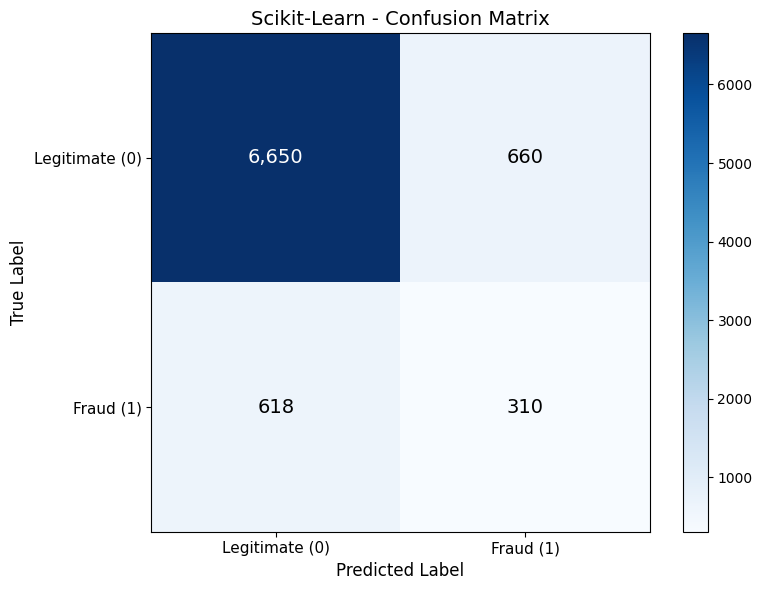

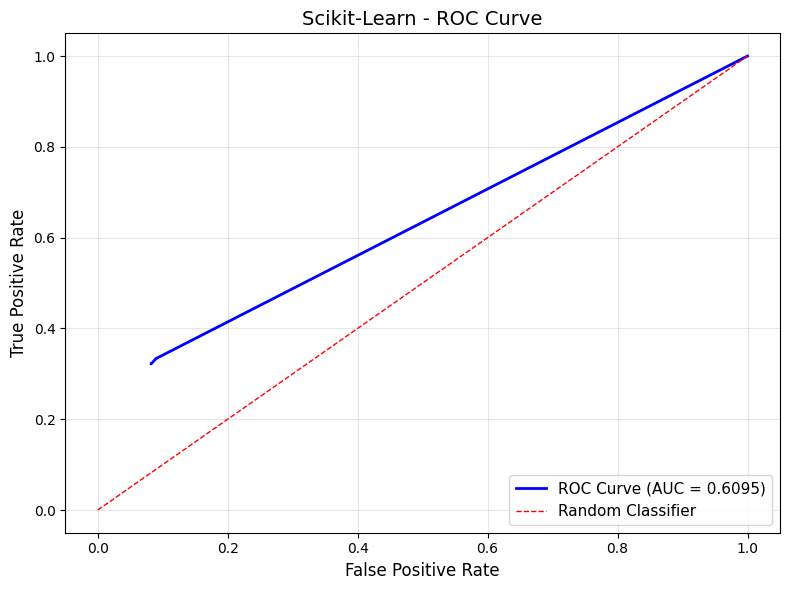

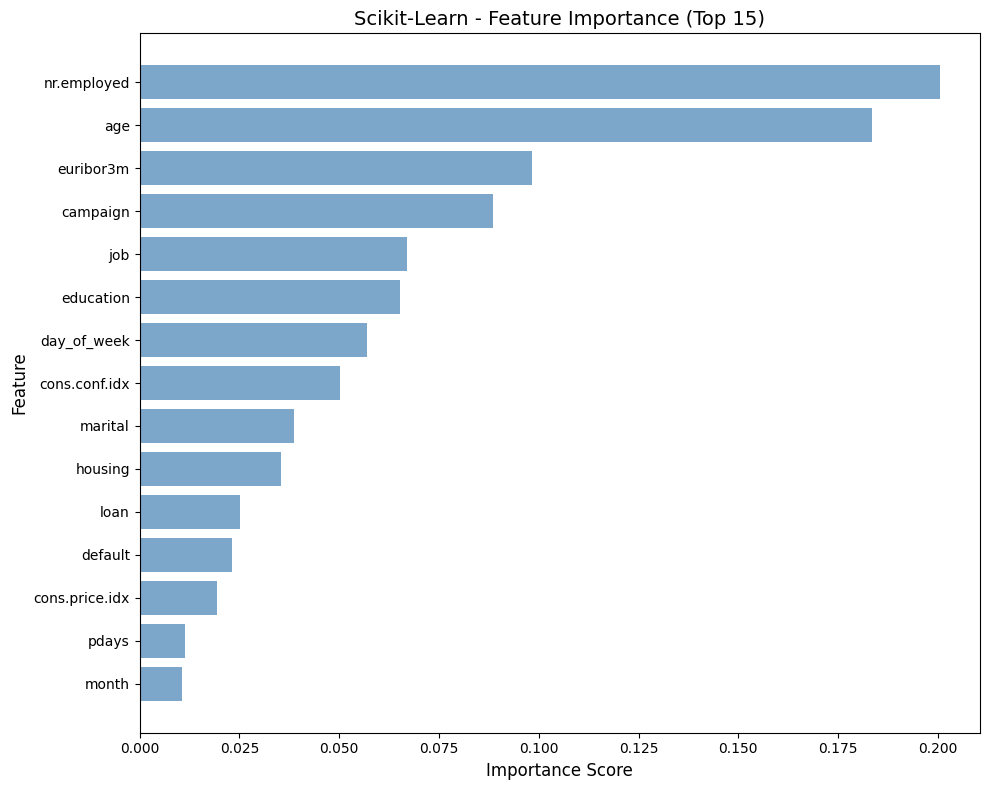

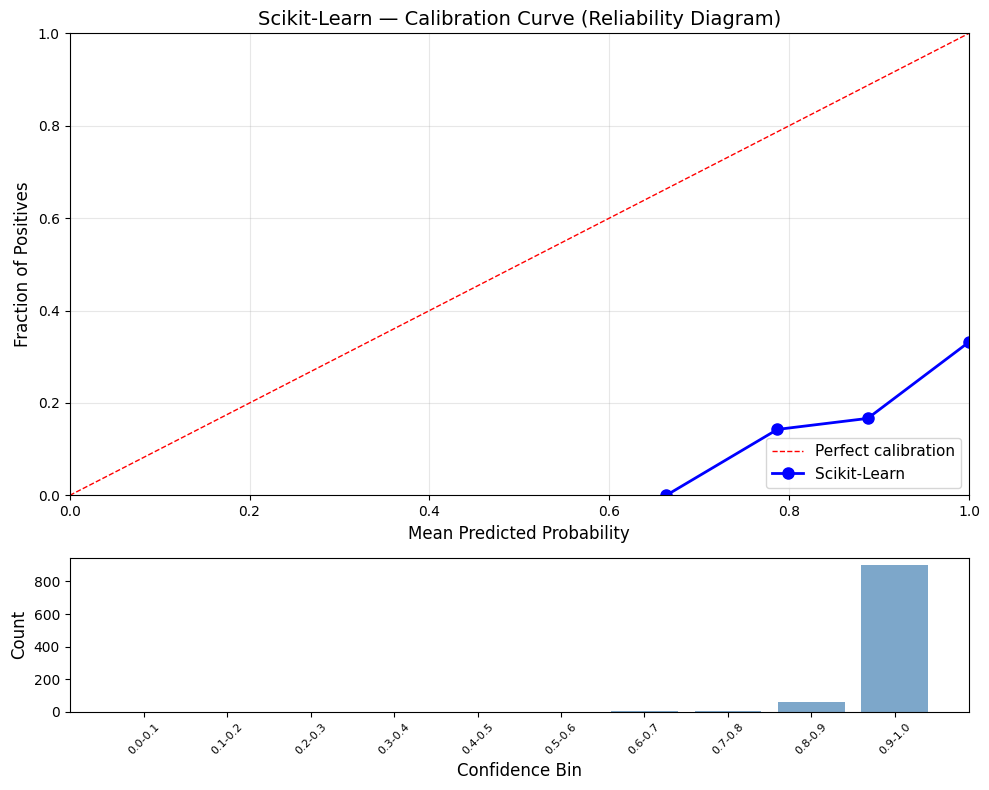


Top 5 features by Gini importance:
  1. nr.employed         : 0.2005
  2. age                 : 0.1834
  3. euribor3m           : 0.0982
  4. campaign            : 0.0886
  5. job                 : 0.0670


In [4]:
# Step 3: Decision Tree visualizations
print("=" * 60)
print("DECISION TREE VISUALIZATIONS")
print("=" * 60)

# Confusion matrix
plot_confusion_matrix(y_test, dt_test_pred, FRAMEWORK,
                      save_path=f'{RESULTS_DIR}/dt_confusion_matrix.png')

# ROC curve
plot_roc_curve(y_test, dt_test_proba, FRAMEWORK,
               save_path=f'{RESULTS_DIR}/dt_roc_curve.png')

# Feature importance (mode='importance' for tree-based non-negative values)
plot_feature_importance(dt_model.feature_importances_, feature_names, FRAMEWORK,
                        save_path=f'{RESULTS_DIR}/dt_feature_importance.png',
                        mode='importance')

# Calibration curve
plot_calibration_curve(y_test, dt_test_proba, FRAMEWORK,
                       save_path=f'{RESULTS_DIR}/dt_calibration.png')

# Print top 5 features
sorted_idx = np.argsort(dt_model.feature_importances_)[::-1]
print("\nTop 5 features by Gini importance:")
for i in range(5):
    idx = sorted_idx[i]
    print(f"  {i+1}. {feature_names[idx]:20s}: {dt_model.feature_importances_[idx]:.4f}")

## Part 2: Random Forest — Fixing Overfitting via Bagging

**How Random Forest improves on a single Decision Tree:**

1. **Bootstrap aggregating (bagging)** — each tree trains on a random sample (with replacement) of the training data, so no single tree sees everything
2. **Random feature subsets** — at each split, only `sqrt(n_features)` features are considered, forcing trees to learn different patterns
3. **Majority vote** — predictions are averaged across all trees, reducing variance (the main source of DT overfitting)
4. **OOB score** — each sample is "out of bag" for ~37% of trees, giving a free validation estimate without a separate validation set

**Expected improvement:** Higher test F1/AUC, much better calibration, reduced overfitting gap.

In [6]:
# PART 2: RANDOM FOREST (Fixes overfitting via bagging)
print("=" * 60)
print("PART 2: RANDOM FOREST (100 Trees)")
print("=" * 60)

"""
n_estimators=100: build 100 trees, each on a bootstrap sample
max_features='sqrt': at each split, consider sqrt(19) ≈ 4 random features
oob_score=True: compute out-of-bag accuracy (free validation)
class_weight='balanced': same imbalance handling as DT
"""
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    class_weight='balanced',
    oob_score=True,
    n_jobs=-1  # use all CPU cores for parallel tree building
)

with track_performance() as rf_perf:
    rf_model.fit(X_train, y_train)

# Predictions + probabilities
rf_train_pred = rf_model.predict(X_train)
rf_train_proba = rf_model.predict_proba(X_train)[:, 1]
rf_test_pred = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate both sets
rf_train_metrics = evaluate_classifier(y_train, rf_train_pred, rf_train_proba)
rf_test_metrics = evaluate_classifier(y_test, rf_test_pred, rf_test_proba)

print(f"\nTraining time: {rf_perf['time']:.4f}s")
print(f"OOB score: {rf_model.oob_score_:.4f}")

print_metrics(rf_train_metrics, rf_test_metrics, title="Random Forest (100 trees)")

# Direct comparison: DT vs RF
print("\n" + "=" * 60)
print("DT vs RF COMPARISON (Test Set)")
print("=" * 60)
print(f"{'Metric':20s} {'DT':>10s} {'RF':>10s} {'Improvement':>12s}")
print("-" * 55)
for metric in ['accuracy', 'f1', 'auc', 'precision', 'recall']:
    dt_val = dt_test_metrics[metric]
    rf_val = rf_test_metrics[metric]
    diff = rf_val - dt_val
    print(f"{metric:20s} {dt_val:10.4f} {rf_val:10.4f} {diff:+11.4f}")

PART 2: RANDOM FOREST (100 Trees)

Training time: 0.8864s
OOB score: 0.8935

METRICS — Random Forest (100 trees)
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.9941       0.8932
precision                       0.9522       0.5513
recall                          0.9981       0.2780
f1                              0.9746       0.3696
auc                             0.9992       0.7773
log_loss                        0.0677       0.4671
brier_score                     0.0135       0.0830
ece                             0.5854       0.6540

DT vs RF COMPARISON (Test Set)
Metric                       DT         RF  Improvement
-------------------------------------------------------
accuracy                 0.8449     0.8932     +0.0483
f1                       0.3267     0.3696     +0.0430
auc                      0.6095     0.7773     +0.1679
precision                0.3196     0.5513     +0.2317
recal

RANDOM FOREST VISUALIZATIONS


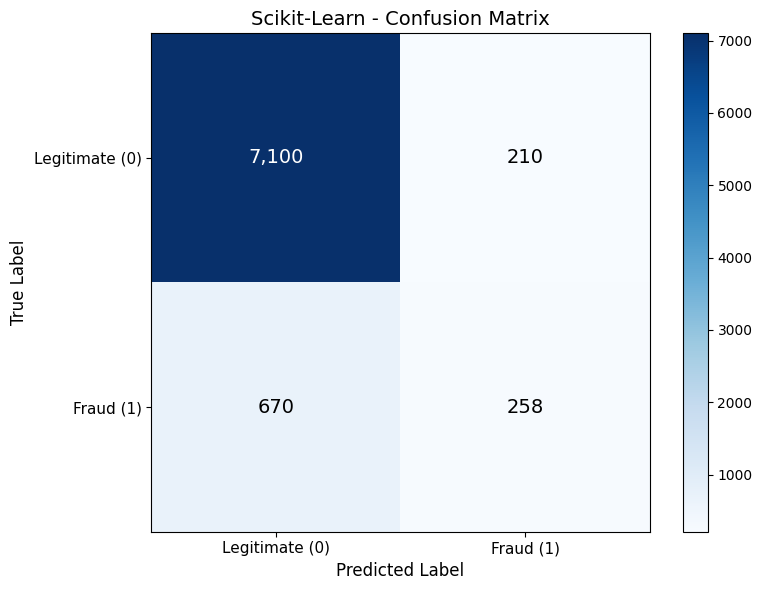

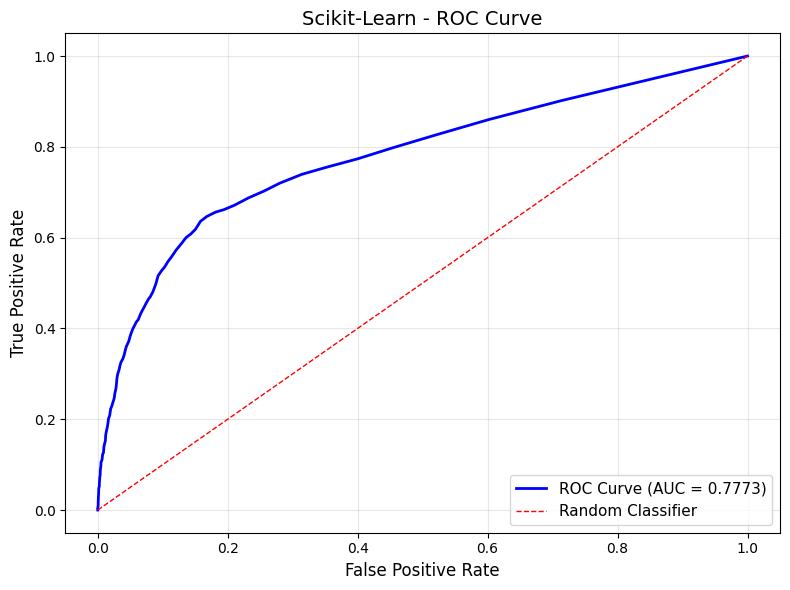

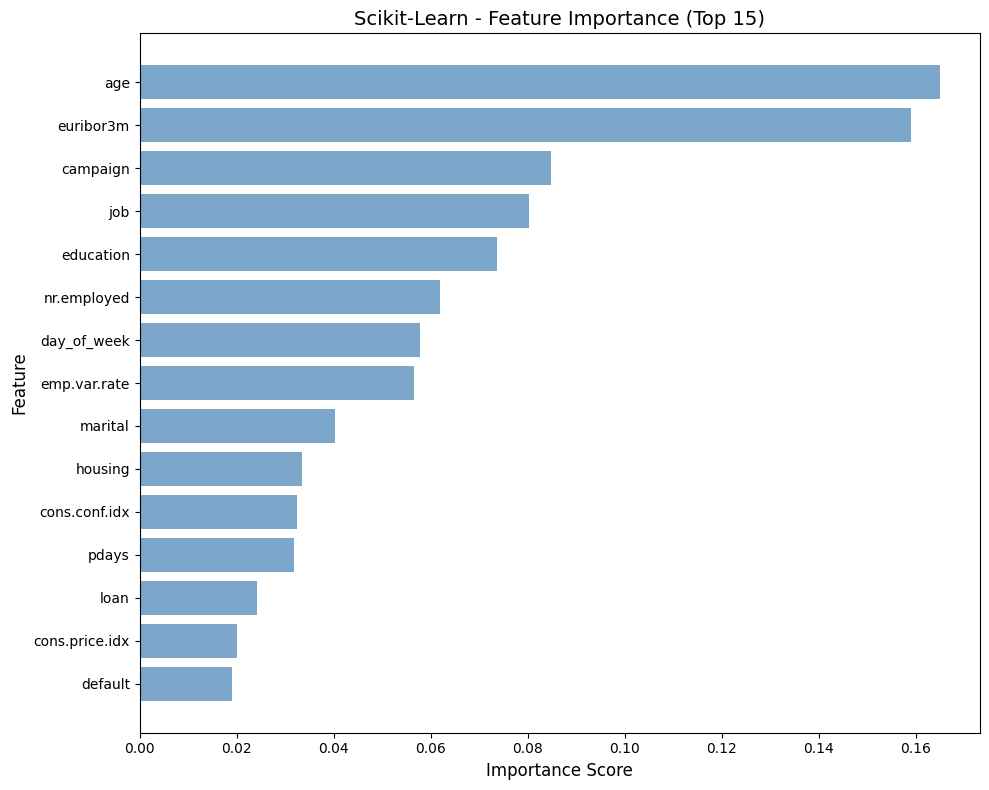

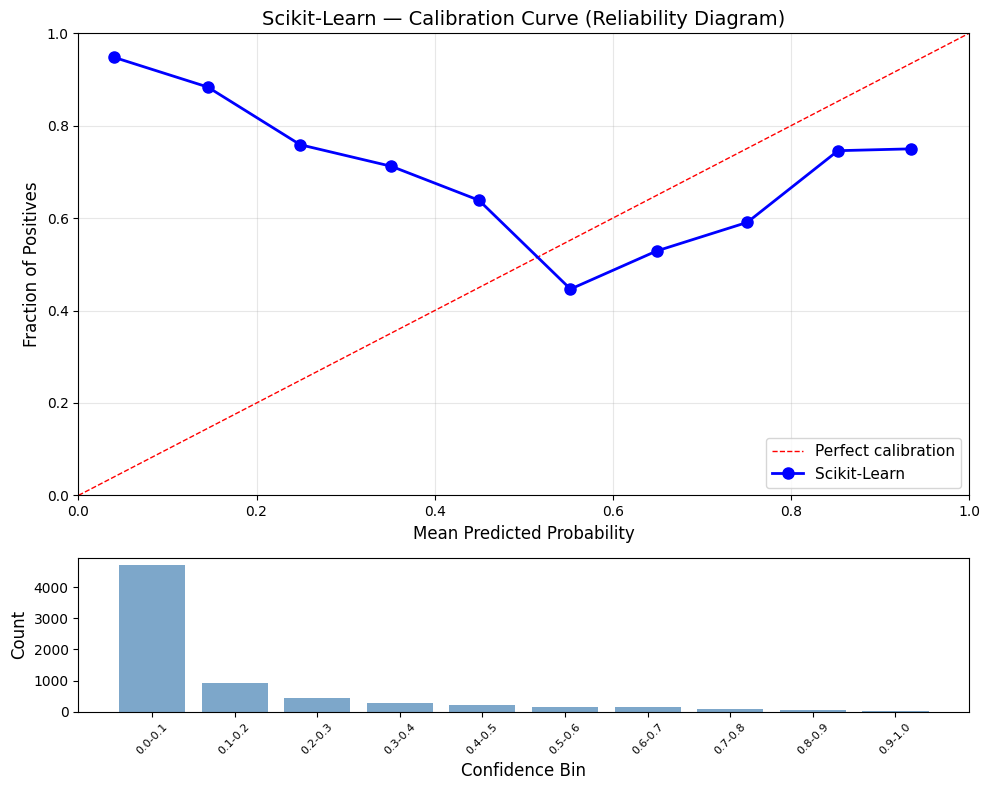

c:\Users\Max\Desktop\Coding\.Projects\2026\ml-framework-comparisons\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\Max\Desktop\Coding\.Projects\2026\ml-framework-comparisons\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\Max\Desktop\Coding\.Projects\2026\ml-framework-comparisons\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\Max\Desktop\Coding\.Projects\2026\ml-framework-comparisons\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

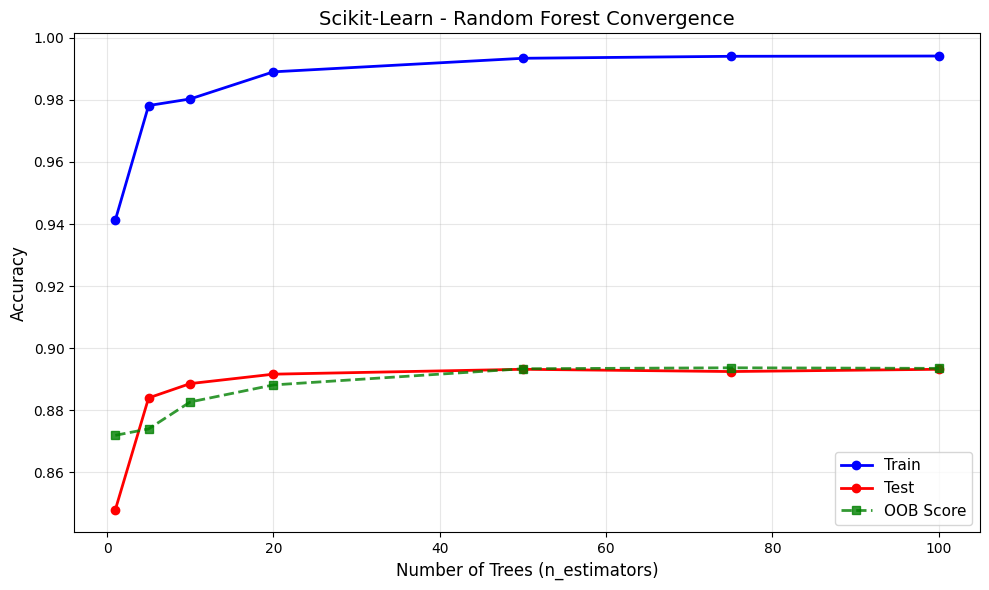


Top 5 features by RF Gini importance (averaged over 100 trees):
  1. age                 : 0.1650
  2. euribor3m           : 0.1589
  3. campaign            : 0.0847
  4. job                 : 0.0802
  5. education           : 0.0738


In [7]:
# Step 4: Random Forest visualizations
print("=" * 60)
print("RANDOM FOREST VISUALIZATIONS")
print("=" * 60)

# Confusion matrix
plot_confusion_matrix(y_test, rf_test_pred, FRAMEWORK,
                      save_path=f'{RESULTS_DIR}/rf_confusion_matrix.png')

# ROC curve
plot_roc_curve(y_test, rf_test_proba, FRAMEWORK,
               save_path=f'{RESULTS_DIR}/rf_roc_curve.png')

# Feature importance (averaged across 100 trees)
plot_feature_importance(rf_model.feature_importances_, feature_names, FRAMEWORK,
                        save_path=f'{RESULTS_DIR}/rf_feature_importance.png',
                        mode='importance')

# Calibration curve
plot_calibration_curve(y_test, rf_test_proba, FRAMEWORK,
                       save_path=f'{RESULTS_DIR}/rf_calibration.png')

# Forest convergence: accuracy vs n_estimators
# Build forests of increasing size and track train/test accuracy
n_est_values = [1, 5, 10, 20, 50, 75, 100]
conv_train = []
conv_test = []
conv_oob = []

for n in n_est_values:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        max_features='sqrt',
        random_state=RANDOM_STATE,
        class_weight='balanced',
        oob_score=True,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)
    conv_train.append(np.mean(rf_temp.predict(X_train) == y_train))
    conv_test.append(np.mean(rf_temp.predict(X_test) == y_test))
    conv_oob.append(rf_temp.oob_score_)

plot_forest_convergence(n_est_values, conv_train, conv_test, FRAMEWORK,
                        oob_scores=conv_oob,
                        save_path=f'{RESULTS_DIR}/rf_convergence.png')

# Print top 5 features (RF)
sorted_idx = np.argsort(rf_model.feature_importances_)[::-1]
print("\nTop 5 features by RF Gini importance (averaged over 100 trees):")
for i in range(5):
    idx = sorted_idx[i]
    print(f"  {i+1}. {feature_names[idx]:20s}: {rf_model.feature_importances_[idx]:.4f}")